In [1]:
# Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from math import ceil
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
os.getcwd()

'D:\\kaggle\\predict_future_sales\\competitive-data-science-predict-future-sales'

### Data Description
#### You are provided with daily historical sales data.
#### The task is to forecast the total amount of products sold in every shop for the test set. 
#### Note that the list of shops and products slightly changes every month. 
#### Creating a robust model that can handle such situations is part of the challenge.

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.


#### Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### Load data

In [2]:
%%time
train=pd.read_csv("sales_train.csv",encoding='utf-8')
test=pd.read_csv("test.csv",encoding='utf-8')
items=pd.read_csv("items.csv",encoding='utf-8')
item_categories=pd.read_csv("item_categories.csv",encoding='utf-8')
shops=pd.read_csv("shops.csv",encoding='utf-8')

Wall time: 1.2 s


In [3]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [4]:
test.head(1)

,ID,shop_id,item_id
0,0,5,5037


In [5]:
items.head(1)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40


In [6]:
item_categories.head(1)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0


In [7]:
shops.head(1)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


### test의 id 들이 train에 다 포함되는지 확인 
* test의 item_id 중 363개는 train에 없음?!

In [8]:
train_shop_id=set(train.shop_id.unique())
train_item_id=set(train.item_id.unique())

test_shop_id=set(test.shop_id.unique())
test_item_id=set(test.item_id.unique())

#각 개수
print("################ shop_id ################")
print("train_shop_id : {}".format(len(train_shop_id)))
print("test_shop_id : {}".format(len(test_shop_id)))
print("train ∩ test : {}".format(len(train_shop_id & test_shop_id)))
print("#########################################")
print()
print("################ item_id ################")
print("train_item_id : {}".format(len(train_item_id)))
print("test_item_id : {}".format(len(test_item_id)))
print("train ∩ test : {}".format(len(train_item_id & test_item_id)))
print("test only {}".format(len(test_item_id)-len(train_item_id & test_item_id)))
print("#########################################")
test_only=test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()

################ shop_id ################
train_shop_id : 60
test_shop_id : 42
train ∩ test : 42
#########################################

################ item_id ################
train_item_id : 21807
test_item_id : 5100
train ∩ test : 4737
test only 363
#########################################


### item_category_id 추가

In [9]:
train=pd.merge(train,items,how="left",on='item_id').drop(columns='item_name')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


### date 열 datetime형으로 변경 

In [10]:
train['date']=pd.to_datetime(train['date'],format='%d.%m.%Y')
train['date'][0:3]

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

### NA 확인 - 모든 열이 NOT NULL 임을 확인

In [11]:
train.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [12]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
date                datetime64[ns]
date_block_num      int64
shop_id             int64
item_id             int64
item_price          float64
item_cnt_day        float64
item_category_id    int64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 179.2 MB


In [14]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37


# column EDA

## [ date ]
* 연 기준: 거래횟수 감소추세 (2013 > 2014 > 2015)
* 월 기준: 12,1,2,3 월 거래횟수 많음
* 일 기준: 거래횟수 비슷비슷

In [15]:
print('[ date ]')
print('- Unique : {}'.format(train.date.nunique()))
print('- Min : {}'.format(train.date.min()))
print('- Max : {}'.format(train.date.max()))

[ date ]
- Unique : 1034
- Min : 2013-01-01 00:00:00
- Max : 2015-10-31 00:00:00


In [16]:
train['year_month']=train['date'].apply(lambda x: x.strftime('%Y-%m'))
train['year']=train.date.dt.year
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year_month,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,37,2013-01,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,58,2013-01,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,58,2013-01,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,58,2013-01,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,56,2013-01,2013,1,15


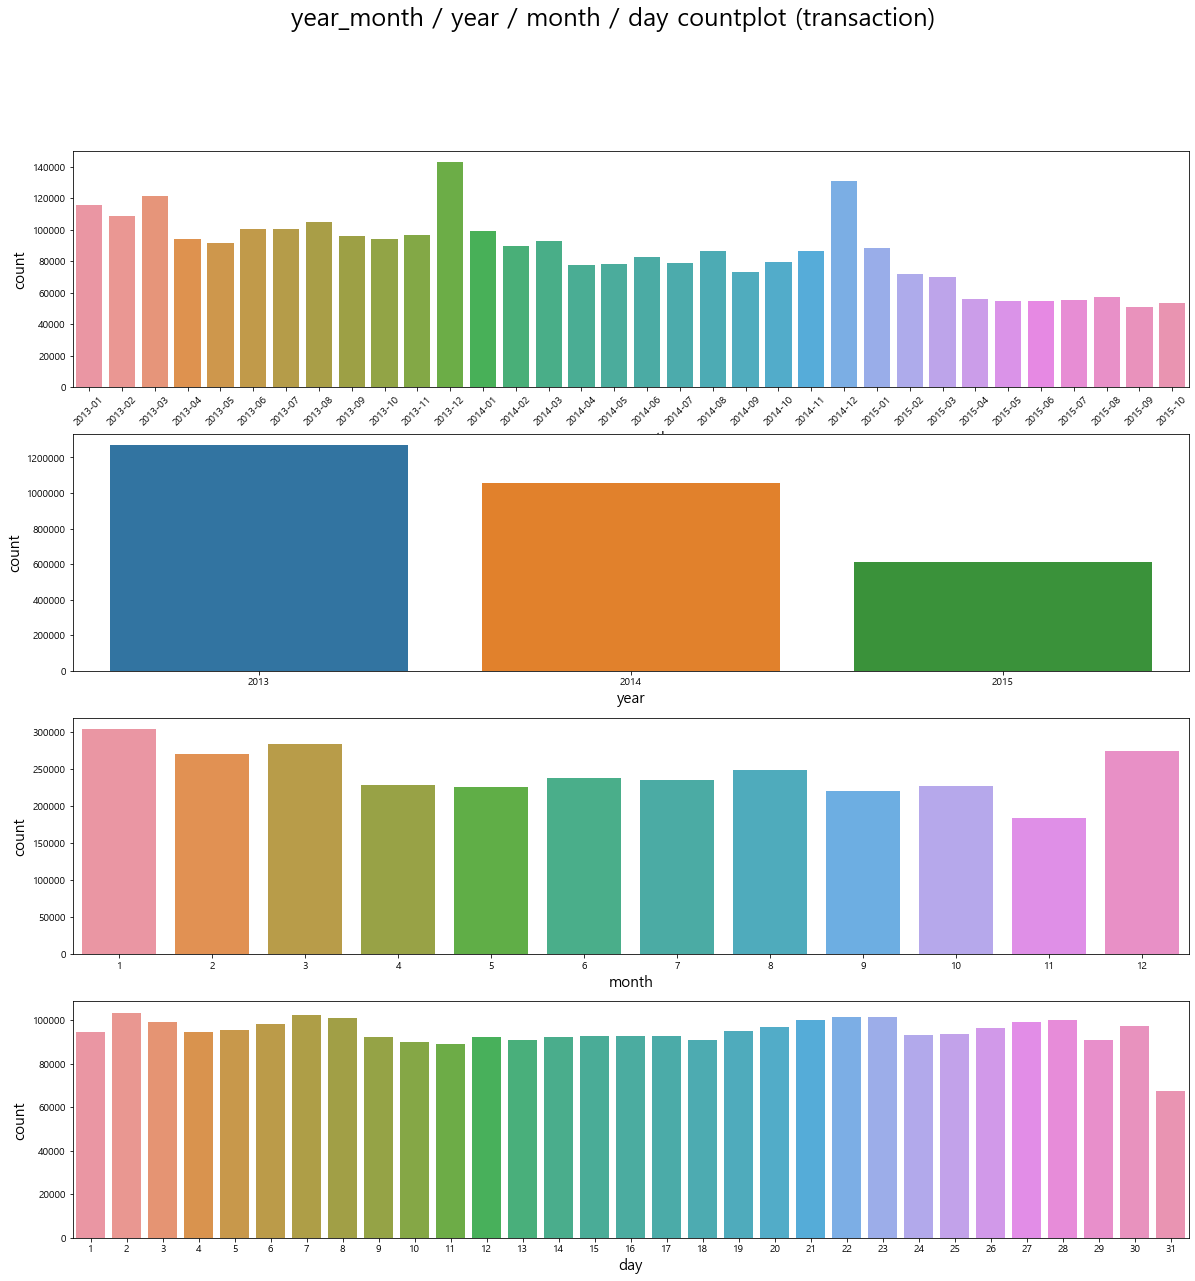

In [17]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))
fig.suptitle('year_month / year / month / day countplot (transaction)', fontsize= 25)
g = sns.countplot(train.year_month, ax=ax[0], order=sorted(train.year_month.unique()))
g.set_xticklabels(g.get_xticklabels(), rotation=45)
sns.countplot(train.year, ax=ax[1])
sns.countplot(train.month, ax=ax[2])
sns.countplot(train.day, ax=ax[3])

## [ date_block_num ]
* 첫 날을 기준으로 1달 간격으로 나눈거 (2013.01 => 0 / 2013.02 =>1 ..... / 2015.12 =>33) 
* date_block_num 변화에 따른 거래량과, 거래액의 변화가 비슷한 양상을 보임

In [18]:
print('[ date_block_num ]'.format(train.date_block_num.nunique()))
print('- Unique : {}'.format(train.date_block_num.nunique()))
print('- Min: {}'.format(train.date_block_num.min()))
print('- Max: {}'.format(train.date_block_num.max()))

[ date_block_num ]
- Unique : 34
- Min: 0
- Max: 33


In [19]:
date_block_num_df=\
    train.groupby('date_block_num')['item_price','item_cnt_day']\
    .agg({'item_price':['sum'],
          'item_cnt_day':['sum']}).reset_index()
date_block_num_df.columns=['date_block_num','item_price_sum','item_cnt_sum']
date_block_num_df[:10]

,date_block_num,item_price_sum,item_cnt_sum
0,0,8.221187e+07,131479.0
1,1,7.558019e+07,128090.0
2,2,8.429831e+07,147142.0
3,3,6.151282e+07,107190.0
4,4,5.727413e+07,106970.0
5,5,6.334361e+07,125381.0
6,6,6.219681e+07,116966.0
7,7,6.543817e+07,125291.0
8,8,7.270157e+07,133332.0
9,9,7.391497e+07,127541.0


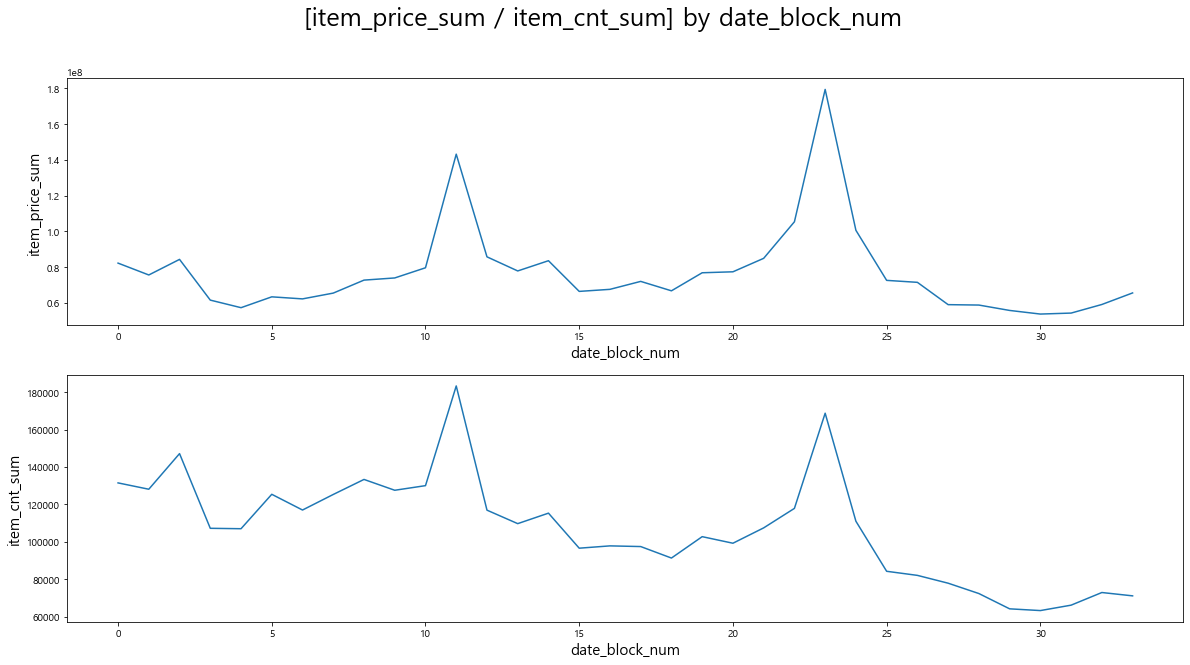

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('[item_price_sum / item_cnt_sum] by date_block_num ', fontsize= 25)
sns.lineplot(x='date_block_num',
             y='item_price_sum',
             data=date_block_num_df,
             ax=ax[0])
sns.lineplot(x='date_block_num',
             y='item_cnt_sum',
             data=date_block_num_df,
             ax=ax[1])

### date_block_num : 월 구분 열에 따라 월 (shop_id,item_id별 데이터 확인)

In [21]:
monthly=pd.DataFrame(
        train.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day']. #그룹핑 및 열 선택
        agg({'date':['min','max'],
             'item_price':['mean'],
             'item_cnt_day':['sum']})).reset_index()
monthly.columns=['date_block_num','shop_id','item_id','date_min','date_max','item_price_mean','item_cnt_sum']
monthly[:10]

,date_block_num,shop_id,item_id,date_min,date_max,item_price_mean,item_cnt_sum
0,0,0,32,2013-01-03,2013-01-31,221.0,6.0
1,0,0,33,2013-01-03,2013-01-28,347.0,3.0
2,0,0,35,2013-01-31,2013-01-31,247.0,1.0
3,0,0,43,2013-01-31,2013-01-31,221.0,1.0
4,0,0,51,2013-01-13,2013-01-31,128.5,2.0
5,0,0,61,2013-01-10,2013-01-10,195.0,1.0
6,0,0,75,2013-01-17,2013-01-17,76.0,1.0
7,0,0,88,2013-01-16,2013-01-16,76.0,1.0
8,0,0,95,2013-01-06,2013-01-06,193.0,1.0
9,0,0,96,2013-01-10,2013-01-10,70.0,1.0


## [ shop_id ]
* 60가지
* 분포 불균형

In [22]:
print('[ shop_id ]')
print('- Unique : {}'.format(train.shop_id.nunique()))
print('- Min: {}'.format(train.shop_id.min()))
print('- Max: {}'.format(train.shop_id.max()))

[ shop_id ]
- Unique : 60
- Min: 0
- Max: 59


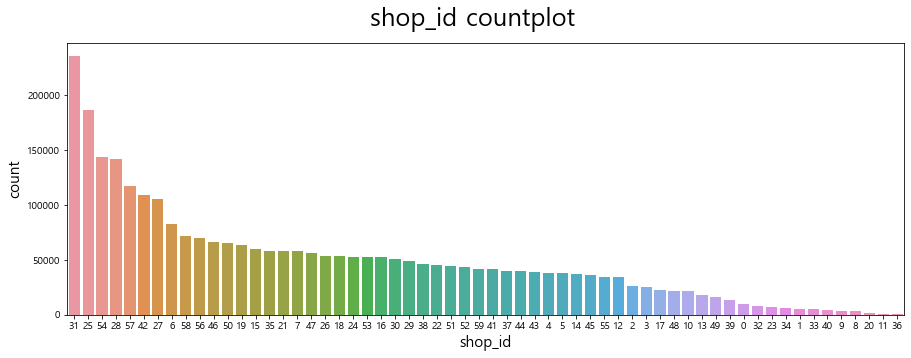

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('shop_id countplot', fontsize= 25)
sns.countplot(train.shop_id,
             order=train.shop_id.value_counts().index)

## [ item_id ]
* 21807 가지
* 사이사이에 비어있는 값이 있음
* 최대 거래횟수 아이템 : 20949 / 31340회
* 최대 판매량 아이템 : 20949 / 187642 개
* 최대 매출 아이템 : 6675 / 113264300(러시아 화폐단위)

In [24]:
print('[ item_id ]')
print('- Unique : {}'.format(train.item_id.nunique()))
print('- Min: {}'.format(train.item_id.min()))
print('- Max: {}'.format(train.item_id.max()))

[ item_id ]
- Unique : 21807
- Min: 0
- Max: 22169


In [25]:
item_id_count_df=pd.DataFrame(train.item_id.value_counts()[:20]).reset_index()
item_id_count_df.columns=['item_id','count']
item_id_count_df.head()

,item_id,count
0,20949,31340
1,5822,9408
2,17717,9067
3,2808,7479
4,4181,6853


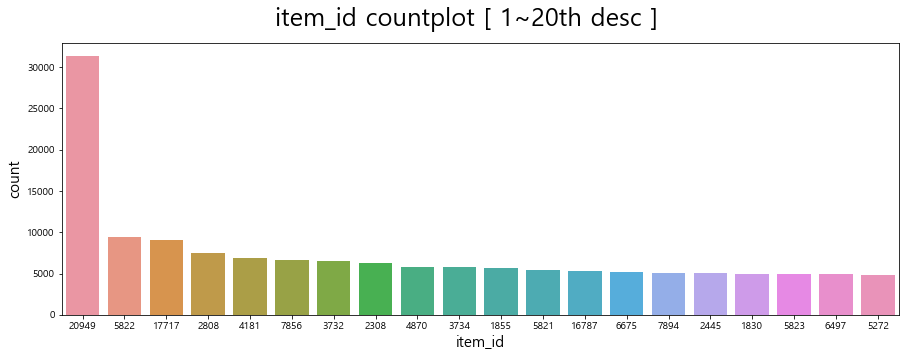

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('item_id countplot [ 1~20th desc ]', fontsize= 25)
sns.barplot(x='item_id',
            y='count',
            data=item_id_count_df,
            order=item_id_count_df.item_id)

In [27]:
train.loc[train.item_id==20949].head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year_month,year,month,day
352379,2013-04-30,3,22,20949,5.000000,12.0,71,2013-04,2013,4,30
352399,2013-04-29,3,22,20949,4.923077,13.0,71,2013-04,2013,4,29
352400,2013-04-28,3,22,20949,5.000000,4.0,71,2013-04,2013,4,28


In [28]:
train.groupby('item_id')['item_price','item_cnt_day'].sum().reset_index().sort_values(by=['item_cnt_day'],ascending=False).reset_index(drop=True)

,item_id,item_price,item_cnt_day
0,20949,1.540316e+05,187642.0
1,2808,7.475887e+06,17245.0
2,3732,1.756505e+07,16642.0
3,17717,9.924972e+06,15830.0
4,5822,9.984311e+06,14515.0
...,...,...,...
21802,7547,6.780000e+03,0.0
21803,13474,1.039800e+04,-1.0
21804,18062,4.999000e+03,-1.0
21805,11871,5.999000e+03,-1.0


In [29]:
train.groupby('item_id')['item_price','item_cnt_day'].sum().reset_index().sort_values(by=['item_price'],ascending=False).reset_index(drop=True)

,item_id,item_price,item_cnt_day
0,6675,1.132643e+08,10289.0
1,13443,2.135946e+07,1366.0
2,3732,1.756505e+07,16642.0
3,3734,1.589006e+07,11688.0
4,5823,1.307078e+07,6523.0
...,...,...,...
21802,3856,1.700000e+01,1.0
21803,7756,1.500000e+01,1.0
21804,22010,1.400000e+01,1.0
21805,13090,1.100000e+01,2.0


## [ item_category_id ]
* 84 가지
* 최대 거래횟수 아이템 카테고리 : 40 / 31340 회
* 최대 판매량 아이템 카테고리 : 40 / 634171 개
* 최대 매출 아이템 카테고리 : 19 / 314836400(러시아 화폐단위)

In [30]:
print('[ item_category_id ]')
print('- Unique : {}'.format(train.item_category_id.nunique()))
print('- Min: {}'.format(train.item_category_id.min()))
print('- Max: {}'.format(train.item_category_id.max()))

[ item_category_id ]
- Unique : 84
- Min: 0
- Max: 83


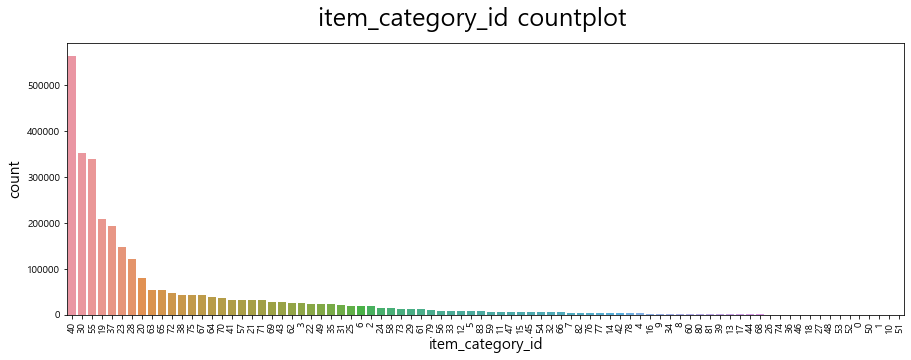

In [31]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
plt.suptitle('item_category_id countplot',fontsize=25)
plt.xticks(rotation=90)
sns.countplot(train.item_category_id
             ,order=train.item_category_id.value_counts().index)

In [32]:
train.groupby('item_category_id')['item_price','item_cnt_day'].sum().reset_index().sort_values(by=['item_cnt_day'],ascending=False).reset_index(drop=True)

,item_category_id,item_price,item_cnt_day
0,40,1.447424e+08,634171.0
1,30,1.755141e+08,456540.0
2,55,9.719241e+07,348591.0
3,19,3.148364e+08,254887.0
4,37,8.367633e+07,203284.0
...,...,...,...
79,50,4.100000e+01,3.0
80,0,2.634000e+02,3.0
81,1,4.310000e+02,2.0
82,10,1.998000e+03,1.0


In [33]:
train.groupby('item_category_id')['item_price','item_cnt_day'].sum().reset_index().sort_values(by=['item_price'],ascending=False).reset_index(drop=True)

,item_category_id,item_price,item_cnt_day
0,19,3.148364e+08,254887.0
1,20,2.207125e+08,127319.0
2,23,2.171441e+08,169944.0
3,30,1.755141e+08,456540.0
4,12,1.694266e+08,13230.0
...,...,...,...
79,1,4.310000e+02,2.0
80,52,3.000000e+02,3.0
81,0,2.634000e+02,3.0
82,51,1.290000e+02,1.0
